In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.ticker import StrMethodFormatter
from enum import Enum, auto
%matplotlib inline
plt.rcParams.update({'font.size': 7})

In [7]:
class View:
    ABSOLUTE=auto()
    ERROR=auto()

def get_data(path, max_t=40):
    df = pd.read_table(path,
                  sep='!!',
                  header=None,
                  names=['t','id','err', 'x-coord', 'target', 'blocklist_size'],
                  dtype={'t': int, 'id': str, 'err': float, 'x-coord': float, 'target': float, 'blocklist_size': int},
                  engine='python')
    df = df[(df['t'] < max_t) & (df['t'] > 0)]
    df = df.set_index('t')
    return df
def get_n_coop(df):
    return df[df['id'].str.contains('fb')].groupby('id').describe().shape[0]
def get_n_byz(df):
    return df[df['id'].str.contains('byz')].groupby('id').describe().shape[0]
def get_n_obs(df):
    return df[df['id'].str.contains('obs')].groupby('id').describe().shape[0]
def plot_tracking_error(df, fig, ax, view=View.ABSOLUTE):
    if view==View.ERROR:
        for i in range(10):
            ax.fill_between(df[(df['id'].str.contains('fb'))].groupby('t')['err'].quantile(0.25).index,
                             df[(df['id'].str.contains('fb'))].groupby('t')['err'].quantile(0.05 * i).values,
                             df[(df['id'].str.contains('fb'))].groupby('t')['err'].quantile(1.0-0.05*i).values,
                             alpha=0.12, color='blue', linewidth=0.)
    elif view==View.ABSOLUTE:
        df.groupby('t').mean(numeric_only=True)['target'].plot(ax=ax, legend=False, color='black', linewidth=1)
        for i in range(10):
            ax.fill_between(df[(df['id'].str.contains('fb'))].groupby('t')['x-coord'].quantile(0.25).index,
                 df[(df['id'].str.contains('fb'))].groupby('t')['x-coord'].quantile(0.05 * i).values,
                 df[(df['id'].str.contains('fb'))].groupby('t')['x-coord'].quantile(1.0-0.05*i).values,
                 alpha=0.12, color='blue', linewidth=0.)
    return fig,ax
def plot_blocklist(df, fig, ax):
    df[(df['id'].str.contains('fb'))].groupby('t').min()['blocklist_size'].plot(ax=ax, linewidth=1, color='black')
    return fig, ax
def plot_cmap(fig, ax):
    f=lambda n:1-(22/25)*(1-0.12)**n
    cmap = colors.ListedColormap([(0.,0.,1.,f(n)) for n in range(10)])
    cmap.set_under('black')
    cmap.set_over('black')
    norm = colors.Normalize(vmin=0.0, vmax=1.)
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                 ticks=np.linspace(0.05,0.95,10), cax=ax, orientation='vertical')
    _=cbar.ax.set_yticklabels(list(map(str,range(100, 9, -10))), fontsize=6)

In [8]:
LEFT,WIDTH=0.0,0.95
BOTTOM,HEIGHT=0.0,0.4
H_SPACING=0.01
V_SPACING=0.05
V_SPACING_DOUBLE_TITLE=0.15
FIGSIZE=(3.2495819444,3.2495819444*2/(1+5**0.5))
FIGSIZE_DOUBLE_TITLE=(FIGSIZE[0], FIGSIZE[1]+V_SPACING_DOUBLE_TITLE)
FIGSIZE_SQUARE=(FIGSIZE[0], FIGSIZE[0])
FIGSIZE_HALF=(FIGSIZE[0], FIGSIZE[1]*(BOTTOM+HEIGHT))

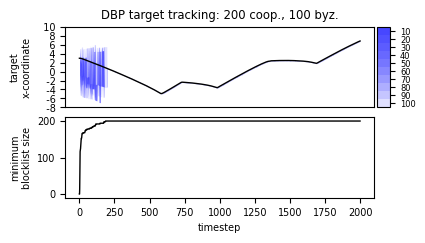

In [9]:
fig=plt.figure(figsize=FIGSIZE)
df=get_data('../experiments/DBP_flocking/flocking_positive-obs.argos.tracking_error', max_t = 2000)
ax1=fig.add_axes([LEFT,BOTTOM+HEIGHT+V_SPACING,WIDTH,HEIGHT])
_=plot_tracking_error(df, fig, ax1)
_=ax1.set_xlabel(None)
_=ax1.set_xticks([])
_=ax1.set_ylabel('target\nx-coordinate')
_=ax1.set_title('DBP target tracking: {} coop., {} byz.'.format(get_n_coop(df), get_n_byz(df)))
_=ax1.set_ylim([-8, 10])
_=ax1.set_yticks(list(range(-8, 11, 2)))
_=ax1.yaxis.set_major_formatter(StrMethodFormatter('{x: >4}'))
cm1=fig.add_axes([LEFT+WIDTH+H_SPACING,BOTTOM+HEIGHT+V_SPACING,1.0-WIDTH-H_SPACING-LEFT,HEIGHT])
plot_cmap(fig,cm1)
ax2=fig.add_axes([LEFT,BOTTOM,WIDTH,HEIGHT])
_=plot_blocklist(df, fig, ax2)
_=ax2.set_xlabel('timestep')
_=ax2.set_ylabel('minimum\nblocklist size')
#fig.align_ylabels([ax1,ax2])
plt.savefig('figs/target-tracking-DBP.svg')

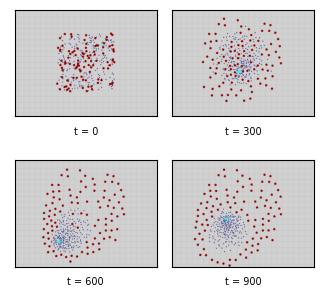

In [10]:
# run the experiment and turn on the recorder to generate the frames
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=FIGSIZE_SQUARE)
ts = list(range(1, 1000, 300))
imgs = [mpimg.imread('../experiments/DBP_flocking/flocking_positive-obs.argos.frames/frame_{0:0>10}.png'.format(i)) for i in ts]
for (i, img) in enumerate(imgs):
    axs[i//2,i%2].imshow(img)
    axs[i//2,i%2].set_xticks([])
    axs[i//2,i%2].set_yticks([])
    axs[i//2,i%2].set_xlabel('t = {}'.format(ts[i]-1))
plt.tight_layout()
plt.savefig('figs/target-tracking-vis.png')

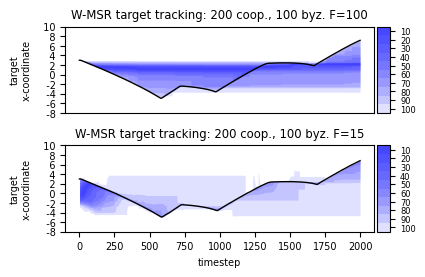

In [11]:
fig=plt.figure(figsize=FIGSIZE_DOUBLE_TITLE)
df=get_data('../experiments/WMSR_flocking/flocking_WMSR.argos.tracking_error', max_t = 2000)
ax1=fig.add_axes([LEFT,BOTTOM+HEIGHT+V_SPACING_DOUBLE_TITLE,WIDTH,HEIGHT])
_=plot_tracking_error(df, fig, ax1)
_=ax1.set_xlabel(None)
_=ax1.set_xticks([])
_=ax1.set_ylabel('target\nx-coordinate')
_=ax1.set_ylim([-8, 10])
_=ax1.set_yticks(list(range(-8, 11, 2)))
_=ax1.set_title('W-MSR target tracking: {} coop., {} byz. F=100'.format(get_n_coop(df), get_n_byz(df)))
_=ax1.yaxis.set_major_formatter(StrMethodFormatter('{x: >4}'))
cm1=fig.add_axes([LEFT+WIDTH+H_SPACING,BOTTOM+HEIGHT+V_SPACING_DOUBLE_TITLE,1.0-WIDTH-H_SPACING-LEFT,HEIGHT])
plot_cmap(fig,cm1)
df=get_data('../experiments/WMSR_flocking/flocking_WMSR_smallF.argos.tracking_error', max_t = 2000)
ax2=fig.add_axes([LEFT,BOTTOM,WIDTH,HEIGHT])
_=plot_tracking_error(df, fig, ax2)
_=ax2.set_xlabel('timestep')
_=ax2.set_ylabel('target\nx-coordinate')
_=ax2.set_ylim([-8, 10])
_=ax2.set_yticks(list(range(-8, 11, 2)))
_=ax2.set_title('W-MSR target tracking: {} coop., {} byz. F=15'.format(get_n_coop(df), get_n_byz(df)))
_=ax2.yaxis.set_major_formatter(StrMethodFormatter('{x: >4}'))
cm2=fig.add_axes([LEFT+WIDTH+H_SPACING,BOTTOM,1.0-WIDTH-H_SPACING-LEFT,HEIGHT])
plot_cmap(fig,cm2)
plt.savefig('figs/target-tracking-WMSR.svg')

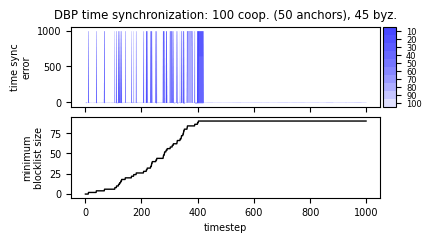

In [12]:
fig=plt.figure(figsize=FIGSIZE)
ax1=fig.add_axes([LEFT,BOTTOM+HEIGHT+V_SPACING,WIDTH,HEIGHT])
df=get_data('../experiments/DBP_time_sync/time_sync.argos.tracking_error', max_t = 1000)
_=plot_tracking_error(df, fig, ax1, view=View.ERROR)
_=ax1.set_xlabel(None)
_=ax1.set_ylabel('time sync\nerror')
_=ax1.set_title('DBP time synchronization: {} coop. ({} anchors), {} byz.'.format(get_n_coop(df), get_n_obs(df), get_n_byz(df)))
cm1=fig.add_axes([LEFT+WIDTH+H_SPACING,BOTTOM+HEIGHT+V_SPACING,1.0-WIDTH-H_SPACING-LEFT,HEIGHT])
plot_cmap(fig,cm1)
ax2=fig.add_axes([LEFT,BOTTOM,WIDTH,HEIGHT])
_=plot_blocklist(df, fig, ax2)
_=ax2.set_xlabel('timestep')
_=ax2.set_ylabel('minimum\nblocklist size')
#fig.align_ylabels([ax1,ax2])
plt.savefig('figs/time-sync-DBP.svg')

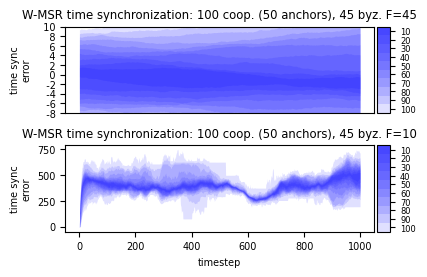

In [13]:
fig=plt.figure(figsize=FIGSIZE_DOUBLE_TITLE)
ax1=fig.add_axes([LEFT,BOTTOM+HEIGHT+V_SPACING_DOUBLE_TITLE,WIDTH,HEIGHT])
df=get_data('../experiments/WMSR_time_sync/time_sync.argos.tracking_error', max_t = 1000)
_=plot_tracking_error(df, fig, ax1, view=View.ERROR)
_=ax1.set_xlabel(None)
_=ax1.set_xticks([])
_=ax1.set_ylabel('time sync\nerror')
_=ax1.set_title('W-MSR time synchronization: {} coop. ({} anchors), {} byz. F=45'.format(get_n_coop(df), get_n_obs(df), get_n_byz(df)))
_=ax1.set_ylim([-8, 10])
_=ax1.set_yticks(list(range(-8, 11, 2)))
_=ax1.yaxis.set_major_formatter(StrMethodFormatter('{x: >4}'))
cm1=fig.add_axes([LEFT+WIDTH+H_SPACING,BOTTOM+HEIGHT+V_SPACING_DOUBLE_TITLE,1.0-WIDTH-H_SPACING-LEFT,HEIGHT])
plot_cmap(fig,cm1)
ax2=fig.add_axes([LEFT,BOTTOM,WIDTH,HEIGHT])
df=get_data('../experiments/WMSR_time_sync/time_sync_smallF.argos.tracking_error', max_t = 1000)
_=plot_tracking_error(df, fig, ax2, view=View.ERROR)
_=ax2.set_xlabel('timestep')
_=ax2.set_ylabel('time sync\nerror')
_=ax2.set_title('W-MSR time synchronization: {} coop. ({} anchors), {} byz. F=10'.format(get_n_coop(df), get_n_obs(df), get_n_byz(df)))
cm2=fig.add_axes([LEFT+WIDTH+H_SPACING,BOTTOM,1.0-WIDTH-H_SPACING-LEFT,HEIGHT])
plot_cmap(fig,cm2)
plt.savefig('figs/time-sync-WMSR.svg')

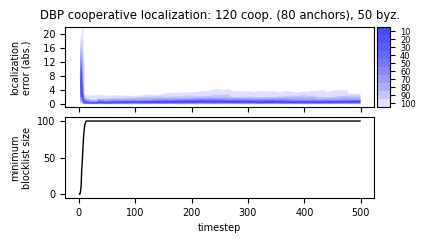

In [14]:
fig=plt.figure(figsize=FIGSIZE)
ax1=fig.add_axes([LEFT,BOTTOM+HEIGHT+V_SPACING,WIDTH,HEIGHT])
df=get_data('../experiments/DBP_localization/localization.argos.tracking_error', max_t = 500)
_=plot_tracking_error(df, fig, ax1, view=View.ERROR)
_=ax1.set_xlabel(None)
_=ax1.set_ylabel('localization\nerror (abs.)')
_=ax1.set_title('DBP cooperative localization: {} coop. ({} anchors), {} byz.'.format(get_n_coop(df), get_n_obs(df), get_n_byz(df)))
_=ax1.set_ylim([-1, 22])
_=ax1.set_yticks(list(range(0, 21, 4)))
_=ax1.yaxis.set_major_formatter(StrMethodFormatter('{x: >4}'))
cm1=fig.add_axes([LEFT+WIDTH+H_SPACING,BOTTOM+HEIGHT+V_SPACING,1.0-WIDTH-H_SPACING-LEFT,HEIGHT])
plot_cmap(fig,cm1)
ax2=fig.add_axes([LEFT,BOTTOM,WIDTH,HEIGHT])
_=plot_blocklist(df, fig, ax2)
_=ax2.set_xlabel('timestep')
_=ax2.set_ylabel('minimum\nblocklist size')
#fig.align_ylabels([ax1,ax2])
plt.savefig('figs/localization-DBP.svg')

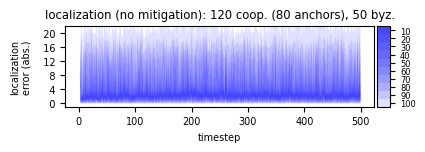

In [15]:
fig=plt.figure(figsize=FIGSIZE_HALF)
ax=fig.add_axes([LEFT,BOTTOM,WIDTH,1.0-BOTTOM])
df=get_data('../experiments/DBP_localization/localization_no-mitigation.argos.tracking_error', max_t = 500)
_=plot_tracking_error(df, fig, ax, view=View.ERROR)
_=ax.set_xlabel('timestep')
_=ax.set_ylabel('localization\nerror (abs.)')
_=ax.set_title('localization (no mitigation): {} coop. ({} anchors), {} byz.'.format(get_n_coop(df), get_n_obs(df), get_n_byz(df)))
_=ax.set_ylim([-1, 22])
_=ax.set_yticks(list(range(0, 21, 4)))
_=ax.yaxis.set_major_formatter(StrMethodFormatter('{x: >4}'))
cm1=fig.add_axes([LEFT+WIDTH+H_SPACING,BOTTOM,1.0-WIDTH-H_SPACING-LEFT,1.0-BOTTOM])
plot_cmap(fig,cm1)
plt.savefig('figs/localization-no-mitigation.svg')